#Asymptotic Bounds using SMT solvers

In this notebook, we will
look at SMT solvers and see how they can be used to formalize and solve certain problems. Particularly, we will show how to show asymptotic bounds using Z3.

**Instructions:**
1. To get started, click on File on the top left and click "Save a copy in Drive."
This will give you an editable version of this document that you can use.
2. If you press `CMD`+`Enter` it runs the cell, and if you press `Shift`+`Enter` it runs the cell and goes to the next one.
3. Make sure you run all cells as you go through the notebook; some cells will not work properly unless the previous one
has been run too.
4. If you disconnect or are inactive for some time you should run all of the cells again.

## 0. Preliminaries (you should run this cell but there is no need to read it)

In [ ]:
!pip install z3-solver
!pip install git+https://github.com/crrivero/FormalMethodsTasting.git#subdirectory=core
from z3 import *
from tofmcore import showSolver, bigOPlot, bigOmegaPlot
from IPython.display import clear_output
clear_output()

## Encoding constraints in Z3

The goal of this notebook is to teach you about formal methods;
particularly, how you can use existing formal verification tools
(in this case, Z3) to analyze and solve your own problems.
Before we get started, let's look at some basic things we can do with Z3.

Let's use Z3 to solve problems involving real numbers. Let's start with something simple: find $x$ such that

$$2x + 5 = 15$$

In [ ]:
# Initialize Z3 solver
s = Solver()

# Initialize variables

x = Real('x') # declaring that x is a real number in Z3 which will also be referred to as x in Python

# we use s.add(.) to add a constraint to our solver s
# here's how we would add the constraint above to our solver:

s.add( 2*x + 5 == 15 ) # add the equation

In [ ]:
# to view the constraints in our solver, we can use the following:
print( s )
# this prints the constraints as they appear in Z3 using Z3's notation

For better readability, this notebook also has a custom print function to view our constraints in LaTeX format, like so:

In [ ]:
showSolver( s )

In [ ]:
# we can use s.check() to run the solver and check whether a solution exists:
print ( s.check() )

 "sat" means our system of constraints is satisfiable, i.e., a solution exists

In [ ]:
# after using s.check(),  we can use s.model() to output a solution if one exsits
solution = s.model()
print( solution )

Now let's try to check whether that's the only solution. We can do this by adding the following constraint to the solver:

$$x \not= 5$$

If the solver returns "**unsat**" then $x=5$ is the only solution.

In [ ]:
s.add( x != 5 )
print( s.check() )

"unsat" means the system is not satisfiable, i.e., there is no real number $x$ that satisfies all the constraints we gave to the solver. **Note that if we were to run s.model() now we would get an error.**

Now it's your turn! **Replace lines in the code below** to find a solution to the following system of equations:
$$ x + 4y = 20 $$
$$ 2x + 3y = 10 $$

In [ ]:
# Initialize Z3 solver
s = Solver()

# Initialize variables

x = Real('x')
y = Real('y')

s.add( x + 4*y == 20 ) # add the first equation
s.add( False ) # REPLACE THIS LINE

showSolver( s ) # view the equations

In [ ]:
print( s.check() ) # check if solution exists

In [ ]:
print( s.model() ) # output solution

Let's look at a slightly more complicated example of what we can achieve with Z3. Consider the following two functions which have also been plotted below:
$$f(x) = 4x$$
$$g(x) = x^2$$
<center>
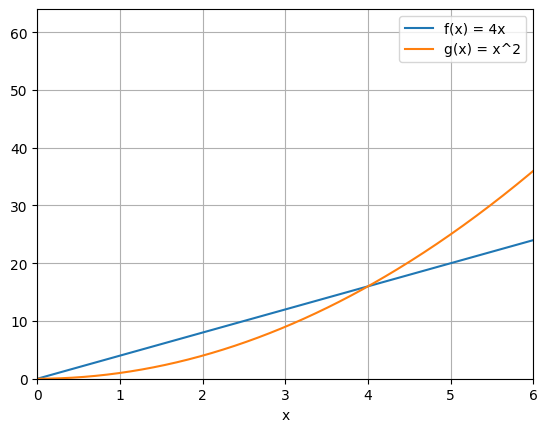
</center>
Note that when $x \geq 4$, we have $g(x) \geq f(x)$. Let's see how we can prove this using Z3.

Formally, we have to show the following:
$$\forall x : x \geq 4 \implies x^2 \geq 4x$$

i.e., for every real $x$, $x \geq 4$ implies that $x^2 \geq 4x$. Let's see how we can encode this using Z3.

In [ ]:
# Initialize Z3 solver
s = Solver()

# Initialize variables

x = Real('x')

# Initialize Functions

f = 4*x
g = pow( x, 2 ) # pow(x,y) is equivalent to x^y

# Construct constraint

impliesConstraint = Implies( x >= 4, g >= f )
# Implies( a, b ) is equivalent to "a ==> b"

forAllConstraint = ForAll( x, impliesConstraint )
# ForAll( a, b ) is equivalent to "For All a : b"

s.add( forAllConstraint  ) # add the constraint

showSolver( s ) # view the constraint

In [ ]:
# Check if true
print( s.check() )

Recall that "sat" means that Z3 has verified the statement for us, so we have succesfully proven that $\forall x : x \geq 4 \implies x^2 \geq 4x$ !

**Now try it yourself! Complete the code below to show that for all values of $x$ in the range $[0,4]$, we have $4x \geq x^2$.**

In [ ]:
# Initialize Z3 solver
s = Solver()

# Initialize variables

x = Real('x')

# Initialize Functions

f = 4*x
g = pow( x, 2 )

# Construct constraint

xRangeConstraint = And( x >= 0, x <= 4 )
# And(a,b) is equivalent to "a and b"

impliesConstraint = Implies( xRangeConstraint, False ) # REPLACE THIS LINE

forAllConstraint = ForAll( x, False ) # REPLACE THIS LINE

s.add( forAllConstraint  ) # add the constraint

showSolver( s ) # view the constraint
s.check()

## Showing $f(n)$ $=$ $O(g(n))$ using Z3

Recall that for two functions $f(n)$ and $g(n)$ we say that $f(n)=O(g(n))$ if and only if there exist constants $c$ and $n_0$ such that

$$\forall n : n \geq n_0 \implies c \cdot g(n) \geq f(n)$$

where $c > 0$.

Using Z3's capabilities that we explored above, we have made the following function to check whether $f(n)=O(g(n))$ given two functions $f$ and $g$ in terms of $n$.

In [ ]:
def makeBigOSolver( f, g ):
  n, c, n0 = Reals('n c n_0')

  # Constraints
  c_positive = c > 0
  big_o_condition = ForAll( n , Implies( n >= n0 , c*g >= f ) )

  s = Solver()
  s.add( c_positive )
  s.add( big_o_condition )
  return s

def bigO( f, g ):
  s = makeBigOSolver( f, g )
  return s.check() == sat

Let's run the cell below to test it out. We show that $n^2 = O\left(\frac{n^3}{100}\right)$:

In [ ]:
n = Real( 'n' )
f = pow(n, 2)
g = pow(n, 3)/100
print( bigO( f, g ) )

We have also defined a function to visualize $g(n)$ "overtaking" $f(n)$, where $c$ and $n_0$ are also output:

In [ ]:
bigOPlot( f, g, makeBigOSolver )

**Complete the code below to show that $ n^2 = O( n^3 - 7n^2 ) $**

In [ ]:
n = Real( 'n' )
f = pow(n, 2)
g = n # REPLACE THIS LINE
bigOPlot( f, g, makeBigOSolver )

Now, using the same approach, we will construct a function that shows $f(n) = \Omega(g(n))$.

## Showing $f(n)$ $=$ $\Omega(g(n))$ using Z3

Recall that for two functions $f(n)$ and $g(n)$ we say that $f(n)=\Omega(g(n))$ if and only if there exist constants $c$ and $n_0$ such that

$$\forall n : n \geq n_0 \implies f(n) \geq c \cdot g(n)$$

where $c > 0$.

**Complete the code below to make a function that shows $f(n)=\Omega(g(n))$ as in the function above:**

In [ ]:
def makeBigOmegaSolver( f, g ):
  n, c, n0 = Reals('n c n_0')

  # Constraints
  c_positive = c > 0
  big_omega_condition = ForAll( n , False ) # REPLACE THIS LINE

  s = Solver()
  s.add( c_positive )
  s.add( big_omega_condition )
  return s

def bigOmega( f, g ):
  s = makeBigOmegaSolver( f, g )
  return s.check() == sat

Let's test your function on some examples below.

Showing that $n^2 = \Omega(n)$.

In [ ]:
n = Real( 'n' )
f = pow(n, 2)
g = n
bigOmegaPlot( f, g, makeBigOmegaSolver )

Showing that $\frac{n^2}{3} - 13n = \Omega(n^2)$.

In [ ]:
n = Real( 'n' )
f = pow(n, 2)/3 - 13*n
g = pow(n, 2)
bigOmegaPlot( f, g, makeBigOmegaSolver )

Showing that $n \not= \Omega\left(\frac{n^2}{10000}\right)$.

In [ ]:
n = Real( 'n' )
f = n
g = pow(n,2)/10000
bigOmegaPlot( f, g, makeBigOmegaSolver )

### Please submit a PDF of your notebook to Gradescope. You can save a PDF by cicking File on the top-left and pressing Print.


### Congratulations! You just wrote an SMT solver for asymptotic bounds!


####If you'd like to continue your Z3 journey, you can start with this guide to learn more:
https://ericpony.github.io/z3py-tutorial/guide-examples.htm